#Download Dataset IS2RE

In [1]:
!wget -c "https://dl.fbaipublicfiles.com/opencatalystproject/data/is2res_train_val_test_lmdbs.tar.gz" -O is2re_dataset.tar.gz

--2025-08-27 10:26:55--  https://dl.fbaipublicfiles.com/opencatalystproject/data/is2res_train_val_test_lmdbs.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.154.144.102, 18.154.144.87, 18.154.144.74, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.154.144.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8593151089 (8.0G) [application/gzip]
Saving to: ‘is2re_dataset.tar.gz’

is2re_dataset.tar.g 100%[===================>]   8.00G  95.4MB/s    in 86s     

2025-08-27 10:28:21 (95.5 MB/s) - ‘is2re_dataset.tar.gz’ saved [8593151089/8593151089]



In [2]:
!tar -xvzf is2re_dataset.tar.gz

is2res_train_val_test_lmdbs/
is2res_train_val_test_lmdbs/data/
is2res_train_val_test_lmdbs/data/is2re/
is2res_train_val_test_lmdbs/data/is2re/all/
is2res_train_val_test_lmdbs/data/is2re/all/val_id/
is2res_train_val_test_lmdbs/data/is2re/all/val_id/data.lmdb
is2res_train_val_test_lmdbs/data/is2re/all/val_id/data.lmdb-lock
is2res_train_val_test_lmdbs/data/is2re/all/val_ood_ads/
is2res_train_val_test_lmdbs/data/is2re/all/val_ood_ads/data.lmdb
is2res_train_val_test_lmdbs/data/is2re/all/val_ood_ads/data.lmdb-lock
is2res_train_val_test_lmdbs/data/is2re/all/val_ood_cat/
is2res_train_val_test_lmdbs/data/is2re/all/val_ood_cat/data.lmdb
is2res_train_val_test_lmdbs/data/is2re/all/val_ood_cat/data.lmdb-lock
is2res_train_val_test_lmdbs/data/is2re/all/val_ood_both/
is2res_train_val_test_lmdbs/data/is2re/all/val_ood_both/data.lmdb
is2res_train_val_test_lmdbs/data/is2re/all/val_ood_both/data.lmdb-lock
is2res_train_val_test_lmdbs/data/is2re/all/test_id/
is2res_train_val_test_lmdbs/data/is2re/all/test_i

In [3]:
!pip install lmdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 6.7 MB/s eta 0:00:00


In [4]:
!pip install torch-geometric==2.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.8 MB/s eta 0:00:00


In [5]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import lmdb
from tqdm import tqdm
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def load_lmdb_data(db_path, num_samples=None):
    """
    Loads data from an LMDB database.

    Parameters:
    -----------
    db_path : str
        Path to the LMDB database
    num_samples : int, optional
        Number of samples to load. If None, load all samples.

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the loaded data
    """
    if not os.path.exists(db_path):
        raise FileNotFoundError(f"Database not found at: {db_path}")

    # Open the LMDB environment
    env = lmdb.open(db_path, subdir=False, readonly=True, lock=False)

    # Lists to store the data
    data_items = []

    # Open a transaction
    with env.begin() as txn:
        # Get a cursor
        cursor = txn.cursor()

        # Determine total number of entries for progress bar
        total_count = env.stat()['entries']
        pbar = tqdm(total=num_samples if num_samples else total_count, desc="Loading data")

        # Iterate over the database
        for idx, (key, value) in enumerate(cursor):
            if num_samples is not None and idx >= num_samples:
                break

            # Safely deserialize without triggering attribute access
            data_object = pickle.loads(value)

            # Access internal attributes directly to avoid PyG's __getattr__
            item = {}
            data_dict = data_object.__dict__

            # Extract all available keys
            for k in data_dict:
                if isinstance(data_dict.get(k), torch.Tensor):
                    item[k] = data_dict.get(k).numpy()
                else:
                    item[k] = data_dict.get(k)

            # Add to our list
            data_items.append(item)
            pbar.update(1)

        pbar.close()

    # Convert to pandas DataFrame for easier handling
    df = pd.DataFrame(data_items)
    return df

# Define dataset paths
train_path = "is2res_train_val_test_lmdbs/data/is2re/all/train/data.lmdb"
val_id_path = "is2res_train_val_test_lmdbs/data/is2re/all/val_id/data.lmdb"

In [7]:
# Load a subset of training data
print("Loading training data sample...")
train_df = load_lmdb_data(train_path)
val_df = load_lmdb_data(val_id_path)

Loading training data sample...


Loading data: 100%|██████████| 24943/24943 [00:30<00:00, 804.96it/s]


In [8]:
train_df

,x,edge_index,edge_attr,pos,norm,face,cell,atomic_numbers,natoms,cell_offsets,force,distances,fixed,sid,tags,y_init,y_relaxed,pos_relaxed
0,None,"[[69, 83, 75, 35, 43, 37, 39, 5, 56, 45, 58, 2...",None,"[[7.0255556, 0.0, 12.73459], [6.9654884, 10.95...",None,None,"[[[11.832515, 0.0, -0.026398], [-3.0482295, 16...","[13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13....",86,"[[0, -1, 0], [0, 0, 0], [0, -1, 0], [0, -1, 0]...","[[0.07672916, 0.03236759, 0.5780765], [0.03831...","[2.811749, 2.811749, 2.811749, 2.8439174, 2.84...","[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",2472718,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, ...",6.282501,-0.025550,"[[7.0255556, 0.0, 12.73459], [6.872939, 10.890..."
1,None,"[[55, 63, 52, 48, 38, 33, 34, 15, 7, 4, 8, 3, ...",None,"[[5.3127055, 11.384256, 12.790607], [5.3127055...",None,None,"[[[12.750493, 0.0, 0.0], [3.1876233, 13.427562...","[40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40....",85,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[-0.4060113, -0.16628616, -0.05275416], [-0.2...","[2.1678982, 2.1678982, 2.1678982, 2.198441, 2....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",1747243,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...",5.972082,-1.837069,"[[5.3127055, 11.384256, 12.790607], [5.3127055..."
2,None,"[[43, 88, 48, 59, 89, 38, 42, 35, 1, 20, 84, 3...",None,"[[0.47911805, 9.925274, 17.310055], [3.051076,...",None,None,"[[[14.120776, 0.0, -0.0], [-0.0, 20.132154, -1...","[19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....",114,"[[0, 0, 0], [-1, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0.10013931, -0.03330279, 0.13222352], [0.040...","[3.5385437, 3.5449479, 3.6219482, 3.6975377, 3...","[0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",1372820,"[1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.497210,-0.423333,"[[0.6374, 9.757039, 17.570086], [3.051076, 10...."
3,None,"[[33, 60, 37, 40, 57, 52, 46, 9, 24, 30, 6, 4,...",None,"[[5.9132943, 5.589967, 15.358818], [2.5504537,...",None,None,"[[[13.451364, 0.0, -0.0], [-0.0, 8.205255, -0....","[44.0, 44.0, 44.0, 44.0, 44.0, 44.0, 44.0, 44....",67,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[0.10401902, -0.12071106, 0.28067988], [-0.22...","[2.4056926, 2.4337132, 2.4337134, 2.4337134, 2...","[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",504664,"[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, ...",9.608648,2.931869,"[[5.9132943, 5.589967, 15.358818], [2.5504537,..."
4,None,"[[38, 50, 36, 49, 43, 44, 55, 39, 7, 19, 5, 17...",None,"[[3.8807034, 2.665027, 15.419543], [0.0, 0.0, ...",None,None,"[[[11.642111, 0.0, -0.0], [3.8807034, 7.995081...","[23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23....",76,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[0.01171777, 0.02433683, -0.2262483], [0.0031...","[2.6693335, 2.6693335, 2.6693335, 2.6693335, 2...","[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",592368,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",6.556396,-1.105795,"[[3.8807034, 2.665027, 15.419543], [0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460323,None,"[[2, 52, 54, 50, 48, 58, 56, 8, 6, 7, 10, 97, ...",None,"[[12.048647, 2.929165, 21.092327], [5.8882155,...",None,None,"[[[14.653774, 0.0, -0.0], [-4.6658235, 10.7225...","[23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23....",100,"[[0, 0, 0], [1, 0, 0], [0, 0, 0], [1, 0, 0], [...","[[-0.15393616, 0.30191508, -0.0152528], [0.023...","[2.3813858, 2.6532042, 2.6532042, 2.6592982, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1959834,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",3.300864,-2.403837,"[[12.129006, 3.0124087, 20.998371], [5.9221373..."
460324,None,"[[114, 130, 110, 126, 118, 134, 26, 54, 46, 74...",None,"[[0.56313276, 4.129608, 13.275588], [0.5631327...",None,None,"[[[9.291478, 0.0, -3.72886], [-0.0, 20.930746,...","[20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20....",160,"[[0, 0, 0], [0, 0, 0], [-1, 0, 0], [-1, 0, 0],...","[[-0.05163236, -0.12640062, -0.35258844], [-0....","[2.858

In [9]:
len(train_df['natoms'].unique())

219

In [10]:
class CatalystDataset(Dataset):
    def __init__(self, df, transform=None, pre_transform=None):
        super(CatalystDataset, self).__init__(transform, pre_transform)
        self.df = df

    def len(self):
        return len(self.df)

    def get(self, idx):
        row = self.df.iloc[idx]
        x = torch.from_numpy(row['atomic_numbers']).long().view(-1, 1)
        edge_index = torch.from_numpy(row['edge_index']).long()
        pos = torch.from_numpy(row['pos']).float()
        tags = torch.from_numpy(row['tags']).long()
        y = torch.tensor([row['y_relaxed']], dtype=torch.float)

        # Include interatomic distances as edge attributes
        edge_attr = torch.from_numpy(row['distances']).float().view(-1, 1)

        data = Data(
            x=x,
            edge_index=edge_index,
            pos=pos,
            y=y,
            tags=tags,
            sid=row['sid'],
            edge_attr=edge_attr  # Add to the data object
        )
        return data

In [11]:
# Create the dataset object
print("\nCreating PyTorch Geometric dataset...")
train_dataset = CatalystDataset(train_df)


Creating PyTorch Geometric dataset...


In [12]:
val_dataset = CatalystDataset(val_df)

In [13]:
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [14]:
# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [15]:
print(f"\nNumber of training samples: {len(train_dataset)}")
print(f"Number of batches in the DataLoader: {len(train_loader)}")


Number of training samples: 460328
Number of batches in the DataLoader: 14386


In [16]:
# Get a single batch
print("\nExample of a single batch from the DataLoader:")
batch = next(iter(train_loader))
print(batch)


Example of a single batch from the DataLoader:
DataBatch(x=[2419, 1], edge_index=[2, 86781], edge_attr=[86781, 1], y=[32], pos=[2419, 3], tags=[2419], sid=[32], batch=[2419], ptr=[33])


In [17]:
# You can inspect the properties of the batch
print(f"\nNumber of graphs in the batch: {batch.num_graphs}")
print(f"Node features shape: {batch.x.shape}")
print(f"Edge index shape: {batch.edge_index.shape}")
print(f"Positions shape: {batch.pos.shape}")
print(f"Target shape: {batch.y.shape}")


Number of graphs in the batch: 32
Node features shape: torch.Size([2419, 1])
Edge index shape: torch.Size([2, 86781])
Positions shape: torch.Size([2419, 3])
Target shape: torch.Size([32])


In [18]:
class IS2RE_GCN(nn.Module):
    def __init__(self, hidden_dim=128, num_layers=4, dropout=0.1):
        super(IS2RE_GCN, self).__init__()
        self.atom_embedding = nn.Embedding(100, hidden_dim)
        self.tag_embedding = nn.Embedding(3, 32)
        self.input_proj = nn.Linear(hidden_dim + 32, hidden_dim)
        self.gcn_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        for _ in range(num_layers):
            self.gcn_layers.append(GCNConv(hidden_dim, hidden_dim))
            self.batch_norms.append(BatchNorm(hidden_dim))
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
        self.dropout = dropout

    def forward(self, batch):
        # CORRECTED: Changed batch.atomic_numbers to batch.x
        atom_emb = self.atom_embedding(batch.x.squeeze(-1))
        tag_emb = self.tag_embedding(batch.tags)

        x = torch.cat([atom_emb, tag_emb], dim=1)
        x = self.input_proj(x)

        for gcn, bn in zip(self.gcn_layers, self.batch_norms):
            residual = x
            x = gcn(x, batch.edge_index)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = x + residual

        x = global_mean_pool(x, batch.batch)
        energy = self.output_proj(x)
        return energy.squeeze(-1)

In [19]:
# Setup device, model, optimizer, and loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = IS2RE_GCN(hidden_dim=128, num_layers=4).to(device)
#Weight_decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss() # Mean Squared Error is suitable for energy regression

In [20]:
# ADD a learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [21]:
print(f"\nUsing device: {device}")
print(f"Model: {model.__class__.__name__}")


Using device: cuda
Model: IS2RE_GCN


In [22]:
def train(loader):
    """Performs one epoch of training."""
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Training"):
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch)
        loss = criterion(pred, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

def evaluate(loader):
    """Evaluates the model on a validation set."""
    model.eval()
    total_mae = 0
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            batch = batch.to(device)
            pred = model(batch)
            # Use Mean Absolute Error (MAE) for a more interpretable metric
            mae = F.l1_loss(pred, batch.y)
            total_mae += mae.item() * batch.num_graphs
    return total_mae / len(loader.dataset)

In [23]:
# --- Main Training Loop with Early Stopping ---

history = {'train_loss': [], 'val_mae': []}
best_val_mae = float('inf')
patience_counter = 0
patience_limit = 15 # Stop after 15 epochs with no improvement

print("\nStarting training with scheduler and early stopping...")
num_epochs = 60
for epoch in range(1, num_epochs + 1):
    train_loss = train(train_loader)
    val_mae = evaluate(val_loader)

    history['train_loss'].append(train_loss)
    history['val_mae'].append(val_mae)

    print(f"Epoch: {epoch:02d}, Train Loss: {train_loss:.4f}, Val MAE: {val_mae:.4f}")

    # Scheduler Step
    scheduler.step(val_mae)

    # Early Stopping Logic
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        patience_counter = 0
        # Optional: save the best model
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"  -> New best validation MAE: {best_val_mae:.4f}. Model saved.")
    else:
        patience_counter += 1
        print(f"  -> No improvement in validation MAE for {patience_counter} epoch(s).")

    if patience_counter >= patience_limit:
        print(f"\nEarly stopping triggered after {epoch} epochs.")
        break


Starting training with scheduler and early stopping...


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 74.12it/s]


Epoch: 01, Train Loss: 2.1057, Val MAE: 0.9593
  -> New best validation MAE: 0.9593. Model saved.


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.12it/s]


Epoch: 02, Train Loss: 1.7383, Val MAE: 0.9055
  -> New best validation MAE: 0.9055. Model saved.


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 71.60it/s]


Epoch: 03, Train Loss: 1.6154, Val MAE: 0.8761
  -> New best validation MAE: 0.8761. Model saved.


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 72.60it/s]


Epoch: 04, Train Loss: 1.5490, Val MAE: 0.8429
  -> New best validation MAE: 0.8429. Model saved.


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 72.31it/s]


Epoch: 05, Train Loss: 1.5083, Val MAE: 0.8411
  -> New best validation MAE: 0.8411. Model saved.


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 72.96it/s]


Epoch: 06, Train Loss: 1.4768, Val MAE: 0.8242
  -> New best validation MAE: 0.8242. Model saved.


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.32it/s]


Epoch: 07, Train Loss: 1.4557, Val MAE: 0.8336
  -> No improvement in validation MAE for 1 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:11<00:00, 67.34it/s]


Epoch: 08, Train Loss: 1.4370, Val MAE: 0.8281
  -> No improvement in validation MAE for 2 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:11<00:00, 69.06it/s]


Epoch: 09, Train Loss: 1.4196, Val MAE: 0.8300
  -> No improvement in validation MAE for 3 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 71.55it/s]


Epoch: 10, Train Loss: 1.4072, Val MAE: 0.8288
  -> No improvement in validation MAE for 4 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.22it/s]


Epoch: 11, Train Loss: 1.3939, Val MAE: 0.8064
  -> New best validation MAE: 0.8064. Model saved.


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 71.21it/s]


Epoch: 12, Train Loss: 1.3855, Val MAE: 0.8098
  -> No improvement in validation MAE for 1 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:11<00:00, 70.40it/s]


Epoch: 13, Train Loss: 1.3764, Val MAE: 0.7994
  -> New best validation MAE: 0.7994. Model saved.


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 72.37it/s]


Epoch: 14, Train Loss: 1.3677, Val MAE: 0.8197
  -> No improvement in validation MAE for 1 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 72.85it/s]


Epoch: 15, Train Loss: 1.3602, Val MAE: 0.8076
  -> No improvement in validation MAE for 2 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 70.95it/s]


Epoch: 16, Train Loss: 1.3531, Val MAE: 0.7909
  -> New best validation MAE: 0.7909. Model saved.


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 72.80it/s]


Epoch: 17, Train Loss: 1.3485, Val MAE: 0.7879
  -> New best validation MAE: 0.7879. Model saved.


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.53it/s]


Epoch: 18, Train Loss: 1.3450, Val MAE: 0.8143
  -> No improvement in validation MAE for 1 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.32it/s]


Epoch: 19, Train Loss: 1.3363, Val MAE: 0.7935
  -> No improvement in validation MAE for 2 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:11<00:00, 70.27it/s]


Epoch: 20, Train Loss: 1.3332, Val MAE: 0.7891
  -> No improvement in validation MAE for 3 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.75it/s]


Epoch: 21, Train Loss: 1.3287, Val MAE: 0.8009
  -> No improvement in validation MAE for 4 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 72.91it/s]


Epoch: 22, Train Loss: 1.3257, Val MAE: 0.7941
  -> No improvement in validation MAE for 5 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.88it/s]


Epoch: 23, Train Loss: 1.3182, Val MAE: 0.7933
  -> No improvement in validation MAE for 6 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.24it/s]


Epoch: 24, Train Loss: 1.2618, Val MAE: 0.7604
  -> New best validation MAE: 0.7604. Model saved.


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 72.23it/s]


Epoch: 25, Train Loss: 1.2494, Val MAE: 0.7627
  -> No improvement in validation MAE for 1 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 74.28it/s]


Epoch: 26, Train Loss: 1.2453, Val MAE: 0.7683
  -> No improvement in validation MAE for 2 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.73it/s]


Epoch: 27, Train Loss: 1.2430, Val MAE: 0.7601
  -> New best validation MAE: 0.7601. Model saved.


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 74.49it/s]


Epoch: 28, Train Loss: 1.2392, Val MAE: 0.7567
  -> New best validation MAE: 0.7567. Model saved.


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.82it/s]


Epoch: 29, Train Loss: 1.2346, Val MAE: 0.7628
  -> No improvement in validation MAE for 1 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.96it/s]


Epoch: 30, Train Loss: 1.2318, Val MAE: 0.7648
  -> No improvement in validation MAE for 2 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 74.83it/s]


Epoch: 31, Train Loss: 1.2294, Val MAE: 0.7570
  -> No improvement in validation MAE for 3 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 74.11it/s]


Epoch: 32, Train Loss: 1.2294, Val MAE: 0.7607
  -> No improvement in validation MAE for 4 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 74.29it/s]


Epoch: 33, Train Loss: 1.2264, Val MAE: 0.7545
  -> New best validation MAE: 0.7545. Model saved.


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.73it/s]


Epoch: 34, Train Loss: 1.2263, Val MAE: 0.7547
  -> No improvement in validation MAE for 1 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.99it/s]


Epoch: 35, Train Loss: 1.2223, Val MAE: 0.7609
  -> No improvement in validation MAE for 2 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.95it/s]


Epoch: 36, Train Loss: 1.2216, Val MAE: 0.7660
  -> No improvement in validation MAE for 3 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.73it/s]


Epoch: 37, Train Loss: 1.2193, Val MAE: 0.7545
  -> No improvement in validation MAE for 4 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.40it/s]


Epoch: 38, Train Loss: 1.2173, Val MAE: 0.7570
  -> No improvement in validation MAE for 5 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.66it/s]


Epoch: 39, Train Loss: 1.2164, Val MAE: 0.7600
  -> No improvement in validation MAE for 6 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.84it/s]


Epoch: 40, Train Loss: 1.1809, Val MAE: 0.7424
  -> New best validation MAE: 0.7424. Model saved.


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.80it/s]


Epoch: 41, Train Loss: 1.1754, Val MAE: 0.7459
  -> No improvement in validation MAE for 1 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.43it/s]


Epoch: 42, Train Loss: 1.1704, Val MAE: 0.7434
  -> No improvement in validation MAE for 2 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.63it/s]


Epoch: 43, Train Loss: 1.1690, Val MAE: 0.7591
  -> No improvement in validation MAE for 3 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.67it/s]


Epoch: 44, Train Loss: 1.1649, Val MAE: 0.7475
  -> No improvement in validation MAE for 4 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.54it/s]


Epoch: 45, Train Loss: 1.1643, Val MAE: 0.7423
  -> New best validation MAE: 0.7423. Model saved.


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 74.35it/s]


Epoch: 46, Train Loss: 1.1637, Val MAE: 0.7389
  -> New best validation MAE: 0.7389. Model saved.


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.38it/s]


Epoch: 47, Train Loss: 1.1620, Val MAE: 0.7440
  -> No improvement in validation MAE for 1 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 74.08it/s]


Epoch: 48, Train Loss: 1.1604, Val MAE: 0.7400
  -> No improvement in validation MAE for 2 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.53it/s]


Epoch: 49, Train Loss: 1.1600, Val MAE: 0.7412
  -> No improvement in validation MAE for 3 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.57it/s]


Epoch: 50, Train Loss: 1.1592, Val MAE: 0.7367
  -> New best validation MAE: 0.7367. Model saved.


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 72.07it/s]


Epoch: 51, Train Loss: 1.1564, Val MAE: 0.7377
  -> No improvement in validation MAE for 1 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 72.84it/s]


Epoch: 52, Train Loss: 1.1574, Val MAE: 0.7395
  -> No improvement in validation MAE for 2 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 72.56it/s]


Epoch: 53, Train Loss: 1.1573, Val MAE: 0.7423
  -> No improvement in validation MAE for 3 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 72.85it/s]


Epoch: 54, Train Loss: 1.1559, Val MAE: 0.7418
  -> No improvement in validation MAE for 4 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.06it/s]


Epoch: 55, Train Loss: 1.1537, Val MAE: 0.7379
  -> No improvement in validation MAE for 5 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.99it/s]


Epoch: 56, Train Loss: 1.1525, Val MAE: 0.7410
  -> No improvement in validation MAE for 6 epoch(s).


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.90it/s]


Epoch: 57, Train Loss: 1.1311, Val MAE: 0.7354
  -> New best validation MAE: 0.7354. Model saved.


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.87it/s]


Epoch: 58, Train Loss: 1.1269, Val MAE: 0.7349
  -> New best validation MAE: 0.7349. Model saved.


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 73.75it/s]


Epoch: 59, Train Loss: 1.1268, Val MAE: 0.7321
  -> New best validation MAE: 0.7321. Model saved.


Evaluating: 100%|██████████| 780/780 [00:10<00:00, 74.07it/s]

Epoch: 60, Train Loss: 1.1224, Val MAE: 0.7343
  -> No improvement in validation MAE for 1 epoch(s).


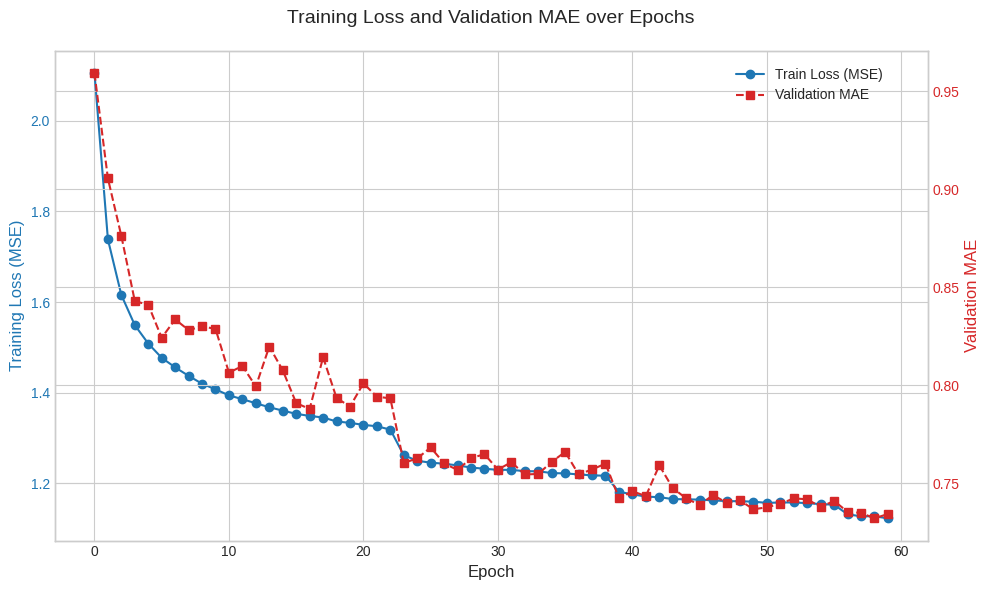

In [24]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Training Loss on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss (MSE)', color=color, fontsize=12)
ax1.plot(history['train_loss'], color=color, marker='o', linestyle='-', label='Train Loss (MSE)')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the Validation MAE
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Validation MAE', color=color, fontsize=12)
ax2.plot(history['val_mae'], color=color, marker='s', linestyle='--', label='Validation MAE')
ax2.tick_params(axis='y', labelcolor=color)

# Final plot adjustments
plt.title('Training Loss and Validation MAE over Epochs', fontsize=14, pad=20)
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.show()


Making predictions on validation set...
Prediction results: MAE = 0.7343, RMSE = 1.0721


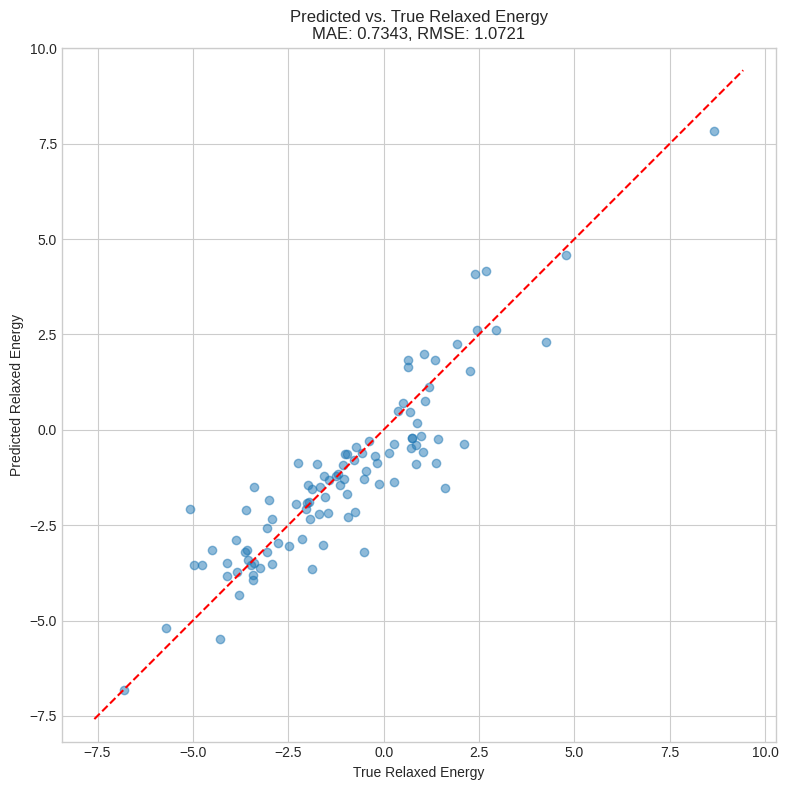

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def predict_and_visualize(model, data_loader, device='cuda', num_samples=100):
    """
    Makes predictions on a dataset and visualizes results.

    Parameters:
    -----------
    model : torch.nn.Module
        The trained GNN model
    data_loader : torch_geometric.data.DataLoader
        DataLoader containing the dataset
    device : str
        Device to use for predictions
    num_samples : int
        Number of samples to visualize in the scatter plot
    """
    # Set device
    device = torch.device(device if torch.cuda.is_available() and device == 'cuda' else 'cpu')
    model = model.to(device)
    model.eval()

    # Lists to store predictions and targets
    all_preds = []
    all_targets = []

    # Make predictions
    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)

            # Forward pass
            output = model(data)

            # Denormalize predictions and targets (removed as no normalization was applied in Dataset)
            pred = output.cpu().numpy() #* target_std + target_mean
            target = data.y.cpu().numpy() #* target_std + target_mean

            all_preds.extend(pred.flatten())
            all_targets.extend(target.flatten())

    # Calculate metrics
    mae = mean_absolute_error(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))

    print(f"Prediction results: MAE = {mae:.4f}, RMSE = {rmse:.4f}")

    # Plot predictions vs. targets
    plt.figure(figsize=(8, 8))

    # Limit to num_samples for clarity in the plot
    if len(all_preds) > num_samples:
        indices = np.random.choice(len(all_preds), num_samples, replace=False)
        plot_preds = [all_preds[i] for i in indices]
        plot_targets = [all_targets[i] for i in indices]
    else:
        plot_preds = all_preds
        plot_targets = all_targets

    # Calculate min and max for axis limits
    min_val = min(min(plot_preds), min(plot_targets))
    max_val = max(max(plot_preds), max(plot_targets))

    # Add some padding to the limits
    padding = (max_val - min_val) * 0.05
    plt.xlim(min_val - padding, max_val + padding)
    plt.ylim(min_val - padding, max_val + padding)

    # Plot the scatter points
    plt.scatter(plot_targets, plot_preds, alpha=0.5)

    # Plot the identity line
    plt.plot([min_val - padding, max_val + padding],
             [min_val - padding, max_val + padding],
             'r--')

    plt.xlabel('True Relaxed Energy')
    plt.ylabel('Predicted Relaxed Energy')
    plt.title(f'Predicted vs. True Relaxed Energy\nMAE: {mae:.4f}, RMSE: {rmse:.4f}')
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# Make predictions on validation set
print("Making predictions on validation set...")
predict_and_visualize(model, val_loader, device=device)

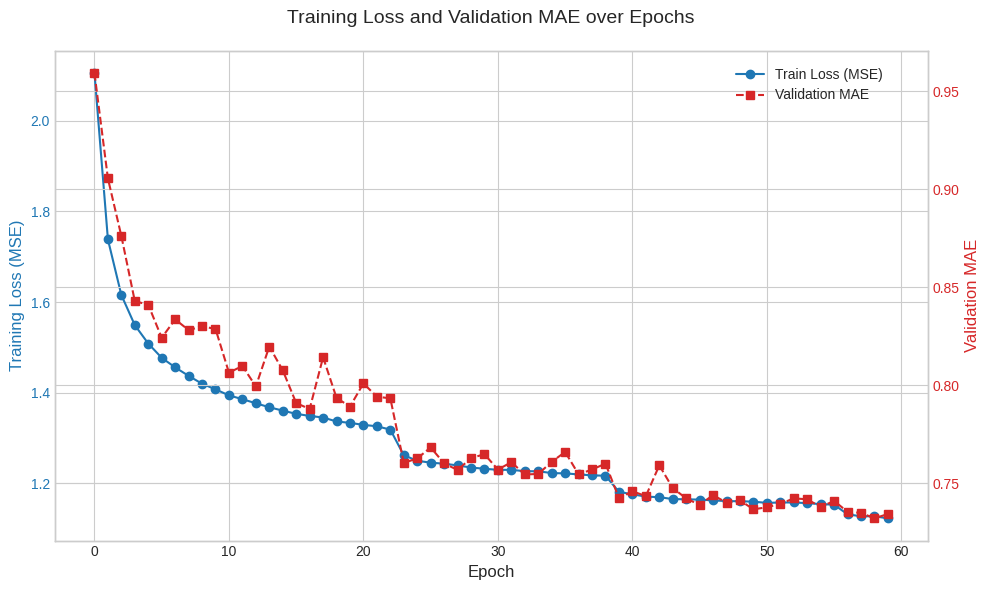

In [26]:
# Plotting the training history (Loss and MAE)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss (MSE)', color=color, fontsize=12)
ax1.plot(history['train_loss'], color=color, marker='o', linestyle='-', label='Train Loss (MSE)')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Validation MAE', color=color, fontsize=12)
ax2.plot(history['val_mae'], color=color, marker='s', linestyle='--', label='Validation MAE')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Training Loss and Validation MAE over Epochs', fontsize=14, pad=20)
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.show()

In [28]:
# Displaying final metrics in a table
final_train_loss = history['train_loss'][-1]
final_val_mae = history['val_mae'][-1]

metrics_data = {'Metric': ['Final Training Loss (MSE)', 'Final Validation MAE'],
                'Value': [final_train_loss, final_val_mae]}
metrics_df = pd.DataFrame(metrics_data)

print("\n--- Final Evaluation Metrics ---")
display(metrics_df)


--- Final Evaluation Metrics ---


,Metric,Value
0,Final Training Loss (MSE),1.122366
1,Final Validation MAE,0.734297



Making predictions on validation set using the best model...


Making predictions: 100%|██████████| 780/780 [01:18<00:00,  9.99it/s]


Prediction results: MAE = 0.7321, RMSE = 1.0755


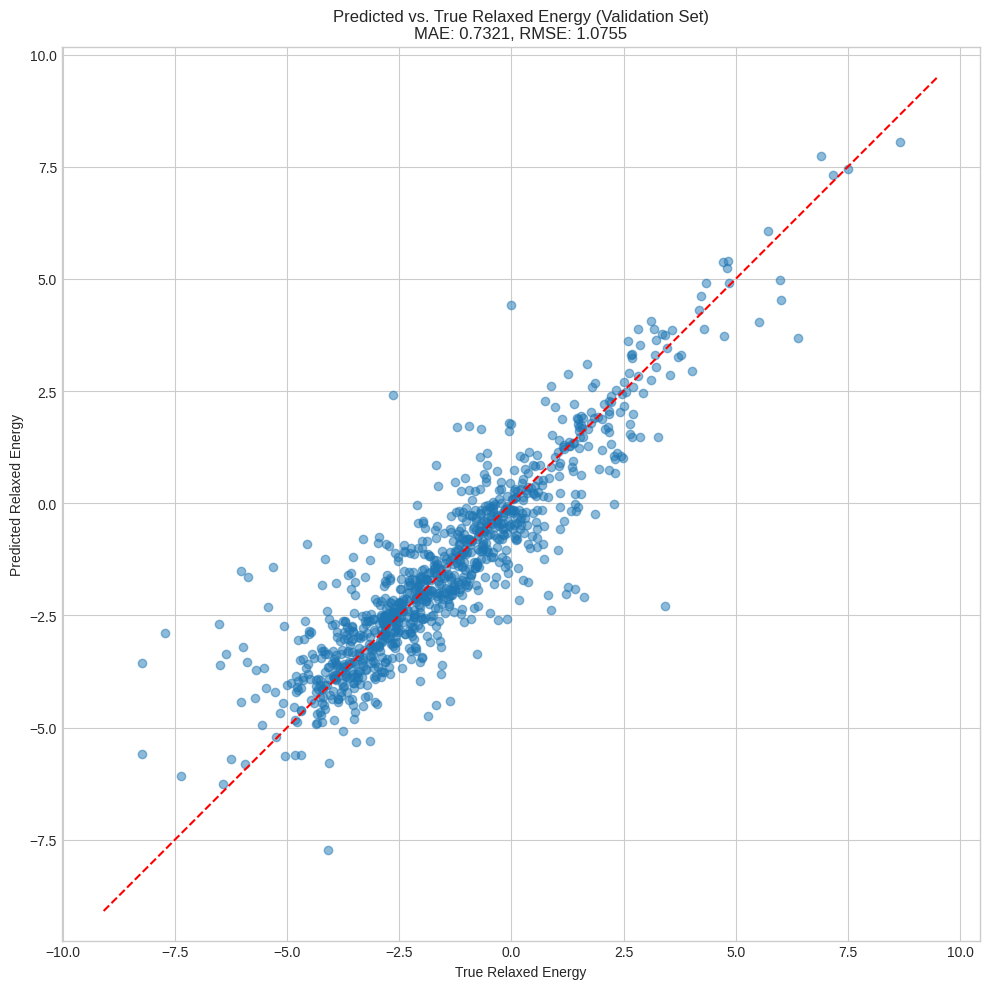

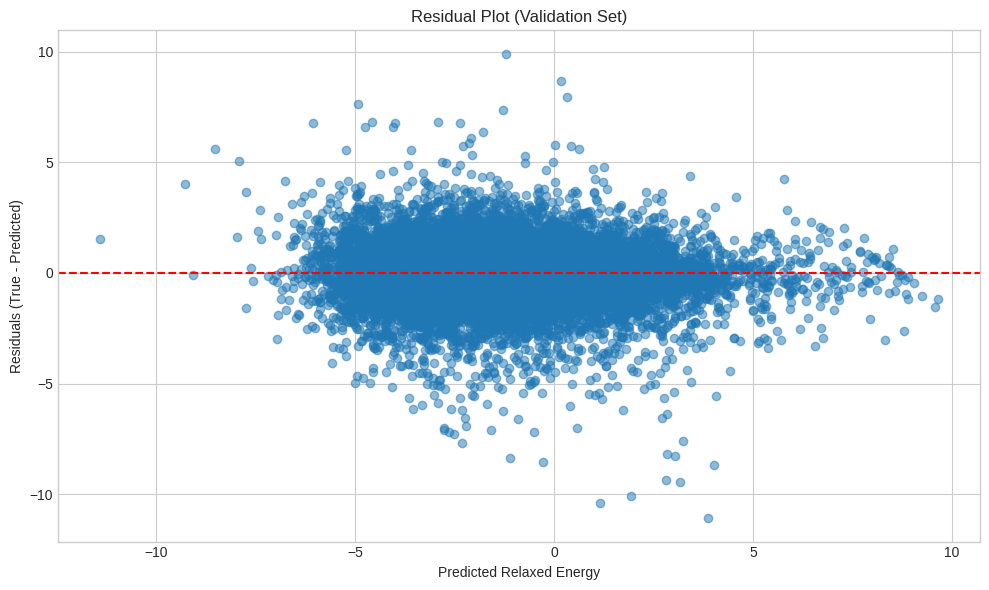

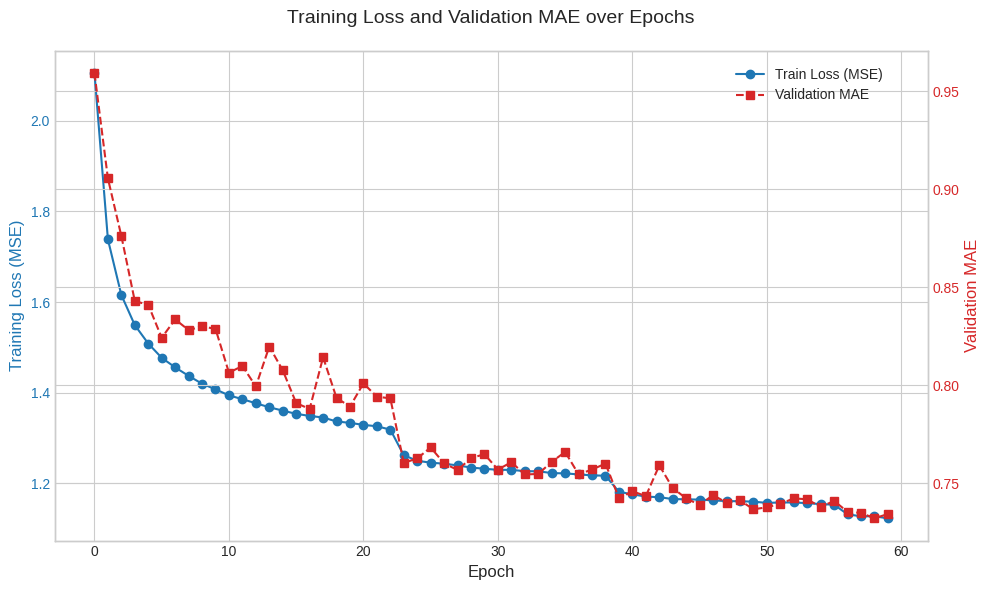


--- Final Evaluation Metrics ---


,Metric,Value
0,Final Training Loss (MSE),1.122366
1,Final Validation MAE,0.734297


In [31]:
def predict_and_visualize(model, data_loader, device='cuda', num_samples=500):
    """
    Makes predictions on a dataset and visualizes results.

    Parameters:
    -----------
    model : torch.nn.Module
        The trained GNN model
    data_loader : torch_geometric.data.DataLoader
        DataLoader containing the dataset
    device : str
        Device to use for predictions
    num_samples : int
        Number of samples to visualize in the scatter plot
    """
    device = torch.device(device if torch.cuda.is_available() and device == 'cuda' else 'cpu')
    model = model.to(device)
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data in tqdm(data_loader, desc="Making predictions"):
            data = data.to(device)
            output = model(data)
            pred = output.cpu().numpy()
            target = data.y.cpu().numpy()

            all_preds.extend(pred.flatten())
            all_targets.extend(target.flatten())

    mae = mean_absolute_error(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))

    print(f"Prediction results: MAE = {mae:.4f}, RMSE = {rmse:.4f}")

    # Create a scatter plot of predictions vs. targets
    plt.figure(figsize=(10, 10))
    if len(all_preds) > num_samples:
        indices = np.random.choice(len(all_preds), num_samples, replace=False)
        plot_preds = [all_preds[i] for i in indices]
        plot_targets = [all_targets[i] for i in indices]
    else:
        plot_preds = all_preds
        plot_targets = all_targets

    min_val = min(min(plot_preds), min(plot_targets))
    max_val = max(max(plot_preds), max(plot_targets))
    padding = (max_val - min_val) * 0.05
    plt.xlim(min_val - padding, max_val + padding)
    plt.ylim(min_val - padding, max_val + padding)

    plt.scatter(plot_targets, plot_preds, alpha=0.5)
    plt.plot([min_val - padding, max_val + padding],
             [min_val - padding, max_val + padding],
             'r--')

    plt.xlabel('True Relaxed Energy')
    plt.ylabel('Predicted Relaxed Energy')
    plt.title(f'Predicted vs. True Relaxed Energy (Validation Set)\nMAE: {mae:.4f}, RMSE: {rmse:.4f}')
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    # Create a residual plot
    residuals = np.array(all_targets) - np.array(all_preds)
    plt.figure(figsize=(10, 6))
    plt.scatter(all_preds, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Relaxed Energy')
    plt.ylabel('Residuals (True - Predicted)')
    plt.title('Residual Plot (Validation Set)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Load the best model weights
model.load_state_dict(torch.load('best_model.pt'))

# Make predictions on validation set using the best model
print("\nMaking predictions on validation set using the best model...")
predict_and_visualize(model, val_loader, device=device, num_samples=1000)

# Plotting the training history (Loss and MAE)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss (MSE)', color=color, fontsize=12)
ax1.plot(history['train_loss'], color=color, marker='o', linestyle='-', label='Train Loss (MSE)')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Validation MAE', color=color, fontsize=12)
ax2.plot(history['val_mae'], color=color, marker='s', linestyle='--', label='Validation MAE')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Training Loss and Validation MAE over Epochs', fontsize=14, pad=20)
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.show()

# Displaying final metrics in a table
final_train_loss = history['train_loss'][-1]
final_val_mae = history['val_mae'][-1]

metrics_data = {'Metric': ['Final Training Loss (MSE)', 'Final Validation MAE'],
                'Value': [final_train_loss, final_val_mae]}
metrics_df = pd.DataFrame(metrics_data)

print("\n--- Final Evaluation Metrics ---")
display(metrics_df)